In [1]:


import import_ipynb
import numpy as np
from PreProcessing_v1 import import_tuh_abnormal
from DataTransform import data_transform, train_valid_test_split, get_parameters_for_model
import torch
from braindecode.preprocessing import preprocess, Preprocessor, scale as multiply
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet, Deep4Net
from torch import optim
from Models import create_model
import seaborn as sns


# # Importing TUH Abnormal dataset

importing Jupyter notebook from PreProcessing_v1.ipynb
importing Jupyter notebook from DataTransform.ipynb
importing Jupyter notebook from Models.ipynb
importing Jupyter notebook from TransformFunction.ipynb


In [2]:

#TUH_PATH = 'C:/Users/Kitti/Documents/Thesis/TUH/Abnormal/SSample'
TUH_PATH = 'TUH EEG Abnormal dataset/Abnormal/' # specify the path to the TUH Abnormal dataset
N_JOBS = 16  # specify the number of jobs for loading and windowing

# parameters to be defined for the preprocessing pipeline
TMIN = 1 * 60
TMAX = 2 * 60 
SFREQ = 100
CLIPPING = 800

In [3]:


tuh_abnormal = import_tuh_abnormal(TUH_PATH, N_JOBS)

In [4]:


def create_ch_mapping():
    short_ch_names = sorted([
        'A1', 'A2',
        'FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
        'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ'])
    ar_ch_names = sorted([
        'EEG A1-REF', 'EEG A2-REF',
        'EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF',
        'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF',
        'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF',
        'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF'])
    le_ch_names = sorted([
        'EEG A1-LE', 'EEG A2-LE',
        'EEG FP1-LE', 'EEG FP2-LE', 'EEG F3-LE', 'EEG F4-LE', 'EEG C3-LE',
        'EEG C4-LE', 'EEG P3-LE', 'EEG P4-LE', 'EEG O1-LE', 'EEG O2-LE',
        'EEG F7-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG T4-LE', 'EEG T5-LE',
        'EEG T6-LE', 'EEG FZ-LE', 'EEG CZ-LE', 'EEG PZ-LE'])
    assert len(short_ch_names) == len(ar_ch_names) == len(le_ch_names)
    ar_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
        ar_ch_names, short_ch_names)}
    le_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
        le_ch_names, short_ch_names)}
    ch_mapping = {'ar': ar_ch_mapping, 'le': le_ch_mapping}    
    return short_ch_names, ch_mapping


def select_by_channels(ds, short_ch_names, ch_mapping):
    split_ids = []
    for i, d in enumerate(ds.datasets):
        ref = 'ar' if d.raw.ch_names[0].endswith('-REF') else 'le'
        # these are the channels we are looking for
        seta = set(ch_mapping[ref].keys())
        # these are the channels of the recoding
        setb = set(d.raw.ch_names)
        # if recording contains all channels we are looking for, include it
        if seta.issubset(setb):
            split_ids.append(i)
    return ds.split(split_ids)['0']


def custom_crop(raw, tmin=0.0, tmax=None, include_tmax=True):
    # crop recordings to tmin – tmax. can be incomplete if recording
    # has lower duration than tmax
    # by default mne fails if tmax is bigger than duration
    tmax = min((raw.n_times - 1) / raw.info['sfreq'], tmax)
    raw.crop(tmin=tmin, tmax=tmax, include_tmax=include_tmax)
    
    
def custom_rename_channels(raw, mapping):
    # rename channels which are dependent on referencing:
    # le: EEG 01-LE, ar: EEG 01-REF
    # mne fails if the mapping contains channels as keys that are not present
    # in the raw
    reference = raw.ch_names[0].split('-')[-1].lower()
    assert reference in ['le', 'ref'], 'unexpected referencing'
    reference = 'le' if reference == 'le' else 'ar'
    raw.rename_channels(mapping[reference])
    
short_ch_names, ch_mapping = create_ch_mapping()

preprocessors = [
        Preprocessor(custom_crop, tmin=TMIN, tmax=TMAX, include_tmax=True,
                     apply_on_array=False),
        Preprocessor('set_eeg_reference', ref_channels='average', ch_type='eeg'), # mne Raw class function
        Preprocessor(custom_rename_channels, mapping=ch_mapping, # rename channels to short channel names
                     apply_on_array=False), #
        Preprocessor('pick_channels', ch_names=short_ch_names, ordered=True), # mne Raw class function
        Preprocessor(multiply, factor=1e6, apply_on_array=True), # scaling signals to microvolt
        Preprocessor(np.clip, a_min=-CLIPPING, a_max=CLIPPING, apply_on_array=True), # clip outlier values to +/- 800 micro volts
        Preprocessor('resample', sfreq=SFREQ), # mne Raw class function
    ]

In [5]:




tuh_preproc = preprocess(
        concat_ds=tuh_abnormal,
        preprocessors=preprocessors,
        n_jobs=N_JOBS,
        save_dir=None
    )


# # Data Transform

In [6]:
TRAIN_SIZE=0.9
tuh_train, tuh_val, tuh_test = train_valid_test_split(tuh_preproc, train_size=TRAIN_SIZE)



In [7]:


# Extract number of chans and time steps from dataset



In [8]:


cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

# Required parameters for model creation
# 
INPUT_WIN_SAMPLES = 6000
INC_CHANS, INPUT_SIZE_SAMPLES = get_parameters_for_model(tuh_train)
N_CLASSES = 2
MODEL_NAME = "shallow" # it can either be shallow, deep, or hybrid
FINAL_CONV_LENGTH = 25

model = create_model(MODEL_NAME, INC_CHANS, N_CLASSES, INPUT_WIN_SAMPLES, FINAL_CONV_LENGTH)


# Send model to GPU
if cuda:
    model.to(device)
    
    

In [9]:
BATCH_SIZE=64
train_loader, val_loader, test_loader = data_transform(tuh_train, tuh_val, tuh_test, model, N_JOBS, train_size=TRAIN_SIZE, batch_size=BATCH_SIZE, input_window_samples=INPUT_WIN_SAMPLES, in_chans = INC_CHANS)

In [10]:


len(train_loader)


# # Training and testing

39

In [12]:


from TrainingValidationTesting_CNNs import train_model, test_model

importing Jupyter notebook from TrainingValidationTesting_CNNs.ipynb


In [13]:


# hyperparameters for training the model
lr =  0.01
optimizer = optim.Adam(params=model.parameters(), lr=lr)
criterion = torch.nn.NLLLoss()
# criterion = torch.nn.BCELoss()
n_epochs = 35  
patience = 10

# Using multiple GPUs
# model = torch.nn.DataParallel(model)

In [ ]:

trained_model, train_losses, train_accs, valid_losses, valid_accs = train_model(model, device, criterion, optimizer, train_loader, val_loader, n_epochs, patience)

In [ ]:


trained_model.to(device)



In [ ]:


x_test, y_test, y_pred, accuracy = test_model(device, trained_model, test_loader)

In [14]:
# Model's path
PATH = './cnnshallow1min.pth'

In [ ]:


# Save the trained model

PATH = './cnnshallow16min.pth'
torch.save(model.state_dict(), PATH)



In [16]:
# to reload the saved model:

model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
x_test, y_test, y_pred, accuracy = test_model(device, model, test_loader)

Accuracy: 0.671


In [18]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

In [19]:
# Reshaping tensors

x_test = x_test.flatten().cpu()
y_test = y_test.flatten().cpu()
y_pred = y_pred.flatten().cpu()

NameError: name 'train_losses' is not defined

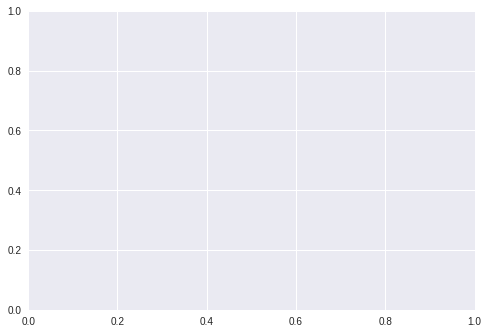

In [20]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.plot(train_losses, marker="o", color="orangered", label="Training loss")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss", color="orangered")

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.plot(train_accs, marker="o", color="cornflowerblue", label="Training accuracy")
ax2.set_ylabel("Accuracy", color="cornflowerblue")

plt.title("Training loss and accuracy per epoch", fontsize=14)
plt.show()


In [ ]:
# Save plot as file
'''
fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')
'''

In [21]:
# In[87]: Learning curve with training and validation loss

plt.plot(train_losses, marker=".", color="cornflowerblue", label='Training loss')
plt.plot(valid_losses, marker=".", color="mediumseagreen", label='Validation loss')
plt.title('Training and Validation Losses', fontsize=14)
plt.xlabel('Number of epochs')
plt.legend(frameon=False)
plt.show()

NameError: name 'train_losses' is not defined

In [22]:
# Learning curve with training and validation accuracy

plt.plot(train_accs, marker=".", color="cornflowerblue", label='Training loss')
plt.plot(valid_losses, marker=".", color="mediumseagreen", label='Validation loss')
plt.title('Training and Validation Losses', fontsize=14)
plt.xlabel('Number of epochs')
plt.legend(frameon=False)
plt.show()

NameError: name 'train_accs' is not defined

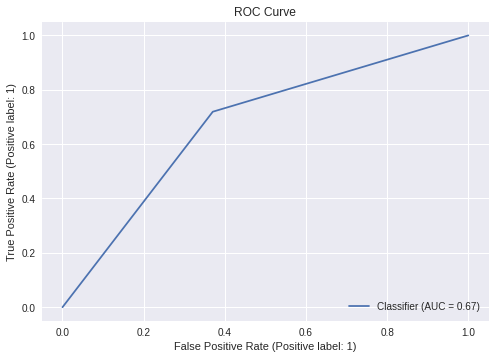

In [27]:
''' 
The ROC Curve plots two parameters: the True Positive Rate (TPR), a synonim to recall,
and the False Positive Rate (FPR). 
The plot also shows the ROC AUC score.
By default, the class considered as the positive (It means Abnormal in our case).

'''

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=None)
plt.title("ROC Curve")
plt.show()


In [24]:
# In[90]: Confusion matrix and Classification Report

conf_matrix = confusion_matrix(y_test, y_pred)
cl_report = classification_report(y_test, y_pred)

In [25]:

print(cl_report)

              precision    recall  f1-score   support

         0.0       0.73      0.63      0.68     55500
         1.0       0.62      0.72      0.67     46620

    accuracy                           0.67    102120
   macro avg       0.67      0.67      0.67    102120
weighted avg       0.68      0.67      0.67    102120



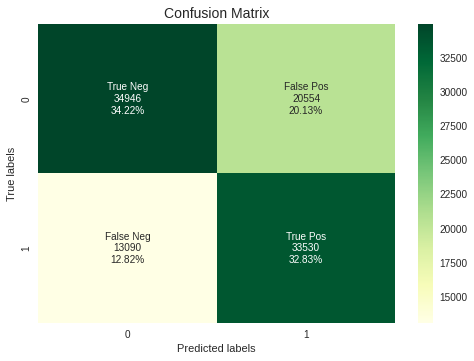

In [26]:
# Confusion matrix

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = plt.axes()
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='YlGn')
ax.set_title('Confusion Matrix', fontsize=14)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()